In [2]:
import os
import tensorflow as tf
# import kaggle
from PIL import Image
import glob
import numpy as np
import shutil
import matplotlib.pyplot as plt
import hashlib
from tensorflow.keras import Sequential,layers,Input,optimizers,utils,callbacks,metrics
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.applications.efficientnet import preprocess_input
# from google.colab import drive
import tensorflow as tf
import numpy as np
import shutil
import os
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    classification_report, confusion_matrix, balanced_accuracy_score,
    roc_auc_score, roc_curve
)
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import time
import os
import torch
import timm
import torch.nn as nn
from torchvision import datasets, transforms
from torch.optim import AdamW
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch
from transformers import ViTForImageClassification, AutoImageProcessor,AutoProcessor, AutoModelForImageClassification
import requests
from io import BytesIO


/Users/gechen/.pyenv/versions/3.10.6/envs/AI_Art_vs_Human_Art/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# get datasets
def get_available_datasets(raw_data_path):
    print("We are getting available datasets.....")
    print("-" * 40)
    datasets = os.listdir(raw_data_path)
    available_datasets = []
    for dataset in datasets:
        train_path= os.path.join(raw_data_path,dataset,"train")
        if os.path.exists(train_path):
            available_datasets.append(dataset)
        else:
            print(f"{dataset} is available")


    print(f"There are {len(available_datasets)} datasets available.")
    print(f"they are {available_datasets}")
    print(f'Done')
    print("-" * 40)
    return available_datasets


In [4]:
raw_data_path = '../raw_data'

In [5]:
available_datasets = get_available_datasets(raw_data_path=raw_data_path)

We are getting available datasets.....
----------------------------------------
.DS_Store is available
There are 7 datasets available.
they are ['imagenet_glide', 'imagenet_midjourney', 'imagenet_ai_0424_wukong', 'imagenet_ai_0508_adm', 'imagenet_ai_0424_sdv5', 'imagenet_ai_0419_vqdm', 'imagenet_ai_0419_biggan']
Done
----------------------------------------


In [6]:
datasets_name = [dataset.split("_")[-1] for dataset in available_datasets]

In [7]:
datasets_name

['glide', 'midjourney', 'wukong', 'adm', 'sdv5', 'vqdm', 'biggan']

In [8]:
merge_path = '/content/drive/MyDrive/Colab Notebooks/AI_vs_human/dataset_multiclass'
source_path = '/content/drive/MyDrive/Colab Notebooks/AI_vs_human/merged_data'
stats = {
    'train':{'glide': 0, 'midjourney':0, 'wukong':0, 'adm':0 , 'sdv5': 0 , 'vqdm':0, 'biggan': 0},
    'val':{'glide': 0, 'midjourney':0, 'wukong':0, 'adm':0 , 'sdv5': 0 , 'vqdm':0, 'biggan': 0}
    }

In [ ]:
# load the data to directory
"""
    only run this cell if you are first time load the dataset in you local machine
"""
for split in ['train','val']:
    for class_name in ['ai','nature']:
        if class_name == 'ai':
            class_path = os.path.join(source_path, split, class_name)
            if not os.path.exists(class_path):
                continue

            target_path = os.path.join(merge_path, split)
            for dataset in datasets_name:
                target_dataset_class_path = os.path.join(target_path, dataset)
                os.makedirs(target_dataset_class_path, exist_ok=True)

                for img_file in os.listdir(class_path):
                    if dataset in img_file.lower() and img_file.lower().endswith(('.jpg', '.jpeg', '.png')):
                        src_file = os.path.join(class_path, img_file)
                        dst_file = os.path.join(target_dataset_class_path, img_file)
                        if os.path.exists(dst_file):
                            continue

                        shutil.copy2(src_file, dst_file)
                       # avoid key error
                        stats[split].setdefault(dataset, 0)
                        stats[split][dataset] += 1

In [10]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
MODEL_NAME = "google/vit-base-patch16-224"
IMG_SIZE = 224
BATCH_SIZE = 32
EPOCHS = 10

LR = 1e-5
WEIGHT_DECAY = 0.01

train_dir = '/content/drive/MyDrive/Colab Notebooks/AI_vs_human/dataset_multiclass/train'
val_dir ='/content/drive/MyDrive/Colab Notebooks/AI_vs_human/dataset_multiclass/val'
BEST_DIR = '../models/practice_multiclass_vit'


In [11]:
DEVICE

device(type='cpu')

In [12]:
# ---- processor (get correct mean/std) ----
processor = AutoImageProcessor.from_pretrained(MODEL_NAME)
mean = processor.image_mean
std = processor.image_std

Fast image processor class <class 'transformers.models.vit.image_processing_vit_fast.ViTImageProcessorFast'> is available for this model. Using slow image processor class. To use the fast image processor class set `use_fast=True`.


In [13]:
# datasets resize,preprocessing, augmentation

train_tfms = transforms.Compose([
    transforms.RandomResizedCrop(IMG_SIZE, scale=(0.95, 1.0), ratio=(0.95, 1.05)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandomRotation(2),  # 你原来的设置，保持不变
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

val_tfms = transforms.Compose([
    # 验证保持确定性
    transforms.Resize(int(IMG_SIZE * 256 / 224)),
    transforms.CenterCrop(IMG_SIZE),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

test_tfms = transforms.Compose([
    #transforms.Resize(int(IMG_SIZE)),
    transforms.ToTensor(),
    transforms.Normalize(mean=mean, std=std),
])

In [ ]:
train_ds = datasets.ImageFolder(train_dir, transform=train_tfms)
val_ds = datasets.ImageFolder(val_dir, transform=val_tfms)

num_classes = len(train_ds.classes)
print("Classes:", train_ds.classes)
print("class_to_idx:", train_ds.class_to_idx)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_ds, batch_size=BATCH_SIZE, shuffle=False, num_workers=4, pin_memory=True)

KeyboardInterrupt: 

In [ ]:
num_classes

7

In [ ]:
id2label = {id : label for id, label in enumerate(train_ds.classes)}

In [ ]:
label2id = {label : id for id, label in enumerate(train_ds.classes)}

In [ ]:
label2id

{'adm': 0,
 'biggan': 1,
 'glide': 2,
 'midjourney': 3,
 'sdv5': 4,
 'vqdm': 5,
 'wukong': 6}

In [ ]:
# ---- model ---
# label2id / id2label
id2label = {id: label for id, label in enumerate(train_ds.classes)}
label2id = {label: id for id, label in enumerate(train_ds.classes)}
print("id2label:", id2label)
print("label2id:", label2id)

model = ViTForImageClassification.from_pretrained(
    MODEL_NAME,
    num_labels=num_classes,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
).to(DEVICE)

criterion = nn.CrossEntropyLoss()
optimizer = AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)

id2label: {0: 'adm', 1: 'biggan', 2: 'glide', 3: 'midjourney', 4: 'sdv5', 5: 'vqdm', 6: 'wukong'}
label2id: {'adm': 0, 'biggan': 1, 'glide': 2, 'midjourney': 3, 'sdv5': 4, 'vqdm': 5, 'wukong': 6}


model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Loading weights:   0%|          | 0/200 [00:00<?, ?it/s]

ViTForImageClassification LOAD REPORT from: google/vit-base-patch16-224
Key               | Status   |                                                                                        
------------------+----------+----------------------------------------------------------------------------------------
classifier.bias   | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([1000]) vs model:torch.Size([7])          
classifier.weight | MISMATCH | Reinit due to size mismatch ckpt: torch.Size([1000, 768]) vs model:torch.Size([7, 768])

Notes:
- MISMATCH	:ckpt weights were loaded, but they did not match the original empty weight shapes.


In [ ]:
print("\n" + "="*60)
print("TRAINING................")
print("="*60)

epochs = 10
train_losses = []
train_accs = []
val_accs = []
val_losses = []

patience = 3
best_val_acc = float("-inf")
best_val_loss = float("inf")
best_epoch = 0
wait = 0

os.makedirs(BEST_DIR, exist_ok=True)

for epoch in range(1, epochs + 1):
    start_time = time.time()

    # Training
    model.train()
    train_correct = 0
    train_total = 0
    train_loss_sum = 0.0  # 按样本加权累计

    for batch_X, batch_y in train_loader:
        batch_X = batch_X.to(DEVICE, non_blocking=True)
        batch_y = batch_y.to(DEVICE, non_blocking=True)

        optimizer.zero_grad(set_to_none=True)

        outputs = model(pixel_values=batch_X)
        logits = outputs.logits

        loss = criterion(logits, batch_y)
        loss.backward()
        optimizer.step()

        bs = batch_X.size(0)
        train_loss_sum += loss.item() * bs

        preds = logits.argmax(dim=1)
        train_correct += (preds == batch_y).sum().item()
        train_total += bs

    train_acc = train_correct / train_total
    avg_train_loss = train_loss_sum / train_total

    # Validation
    model.eval()
    val_correct = 0
    val_total = 0
    val_loss_sum = 0.0

    with torch.no_grad():
        for batch_X, batch_y in val_loader:
            batch_X = batch_X.to(DEVICE, non_blocking=True)
            batch_y = batch_y.to(DEVICE, non_blocking=True)

            outputs = model(pixel_values=batch_X)
            logits = outputs.logits

            loss = criterion(logits, batch_y)

            bs = batch_X.size(0)
            val_loss_sum += loss.item() * bs

            preds = logits.argmax(dim=1)
            val_correct += (preds == batch_y).sum().item()
            val_total += bs

    val_acc = val_correct / val_total
    avg_val_loss = val_loss_sum / val_total

    # Store metrics
    train_losses.append(avg_train_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)
    val_losses.append(avg_val_loss)

    epoch_time = time.time() - start_time
    print(f"\nEpoch {epoch}/{epochs} - Time: {epoch_time:.1f}s ({epoch_time/60:.1f} min)")
    print(f"  Train - Loss: {avg_train_loss:.4f}, Acc: {train_acc:.4f} ({train_acc*100:.2f}%)")
    print(f"  Val   - Loss: {avg_val_loss:.4f}, Acc: {val_acc:.4f} ({val_acc*100:.2f}%)")

    # save best model (based on val_acc)
    improved = avg_val_loss < best_val_loss - 1e-6
    if improved:
        best_val_loss = avg_val_loss
        best_epoch = epoch
        wait = 0
        model.save_pretrained(BEST_DIR)
        processor.save_pretrained(BEST_DIR)
        print(f"best epoch updated to {best_epoch}")
        print(f"best validation loss updated to {best_val_loss:.4f}")
        print(f"best model saved at path {BEST_DIR}")
    else:
        wait += 1
        print(f"val loss did not improve (wait={wait}/{patience})")  # ✅ 文案修正

    # early stop
    if wait >= patience:
        print(f"Early stopping at epoch {epoch}")
        print(f"Best epoch: {best_epoch}")
        print(f"Best val loss: {best_val_loss:.4f}")  # ✅ 修正
        break

print("\n✓ Training complete!")


TRAINING................

Epoch 1/10 - Time: 1358.6s (22.6 min)
  Train - Loss: 1.3688, Acc: 0.4745 (47.45%)
  Val   - Loss: 0.7227, Acc: 0.7246 (72.46%)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to 1
best validation loss updated to 0.7227
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_multiclass_vit

Epoch 2/10 - Time: 221.0s (3.7 min)
  Train - Loss: 0.4390, Acc: 0.8346 (83.46%)
  Val   - Loss: 0.4993, Acc: 0.8120 (81.20%)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to 2
best validation loss updated to 0.4993
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_multiclass_vit

Epoch 3/10 - Time: 230.0s (3.8 min)
  Train - Loss: 0.2654, Acc: 0.9004 (90.04%)
  Val   - Loss: 0.4643, Acc: 0.8137 (81.37%)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to 3
best validation loss updated to 0.4643
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_multiclass_vit

Epoch 4/10 - Time: 229.7s (3.8 min)
  Train - Loss: 0.1846, Acc: 0.9311 (93.11%)
  Val   - Loss: 0.4122, Acc: 0.8391 (83.91%)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to 4
best validation loss updated to 0.4122
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_multiclass_vit

Epoch 5/10 - Time: 230.0s (3.8 min)
  Train - Loss: 0.1314, Acc: 0.9553 (95.53%)
  Val   - Loss: 0.4277, Acc: 0.8420 (84.20%)
val loss did not improve (wait=1/3)

Epoch 6/10 - Time: 225.3s (3.8 min)
  Train - Loss: 0.0899, Acc: 0.9719 (97.19%)
  Val   - Loss: 0.4039, Acc: 0.8523 (85.23%)


Writing model shards:   0%|          | 0/1 [00:00<?, ?it/s]

best epoch updated to 6
best validation loss updated to 0.4039
best model saved at path /content/drive/MyDrive/Colab Notebooks/AI_vs_human/models/practice_multiclass_vit

Epoch 7/10 - Time: 230.2s (3.8 min)
  Train - Loss: 0.0556, Acc: 0.9845 (98.45%)
  Val   - Loss: 0.4105, Acc: 0.8609 (86.09%)
val loss did not improve (wait=1/3)

Epoch 8/10 - Time: 225.4s (3.8 min)
  Train - Loss: 0.0413, Acc: 0.9893 (98.93%)
  Val   - Loss: 0.4589, Acc: 0.8474 (84.74%)
val loss did not improve (wait=2/3)

Epoch 9/10 - Time: 225.6s (3.8 min)
  Train - Loss: 0.0289, Acc: 0.9922 (99.22%)
  Val   - Loss: 0.4306, Acc: 0.8623 (86.23%)
val loss did not improve (wait=3/3)
Early stopping at epoch 9
Best epoch: 6
Best val loss: 0.4039

✓ Training complete!


/tmp/ipython-input-2833635012.py:11: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax1.legend()


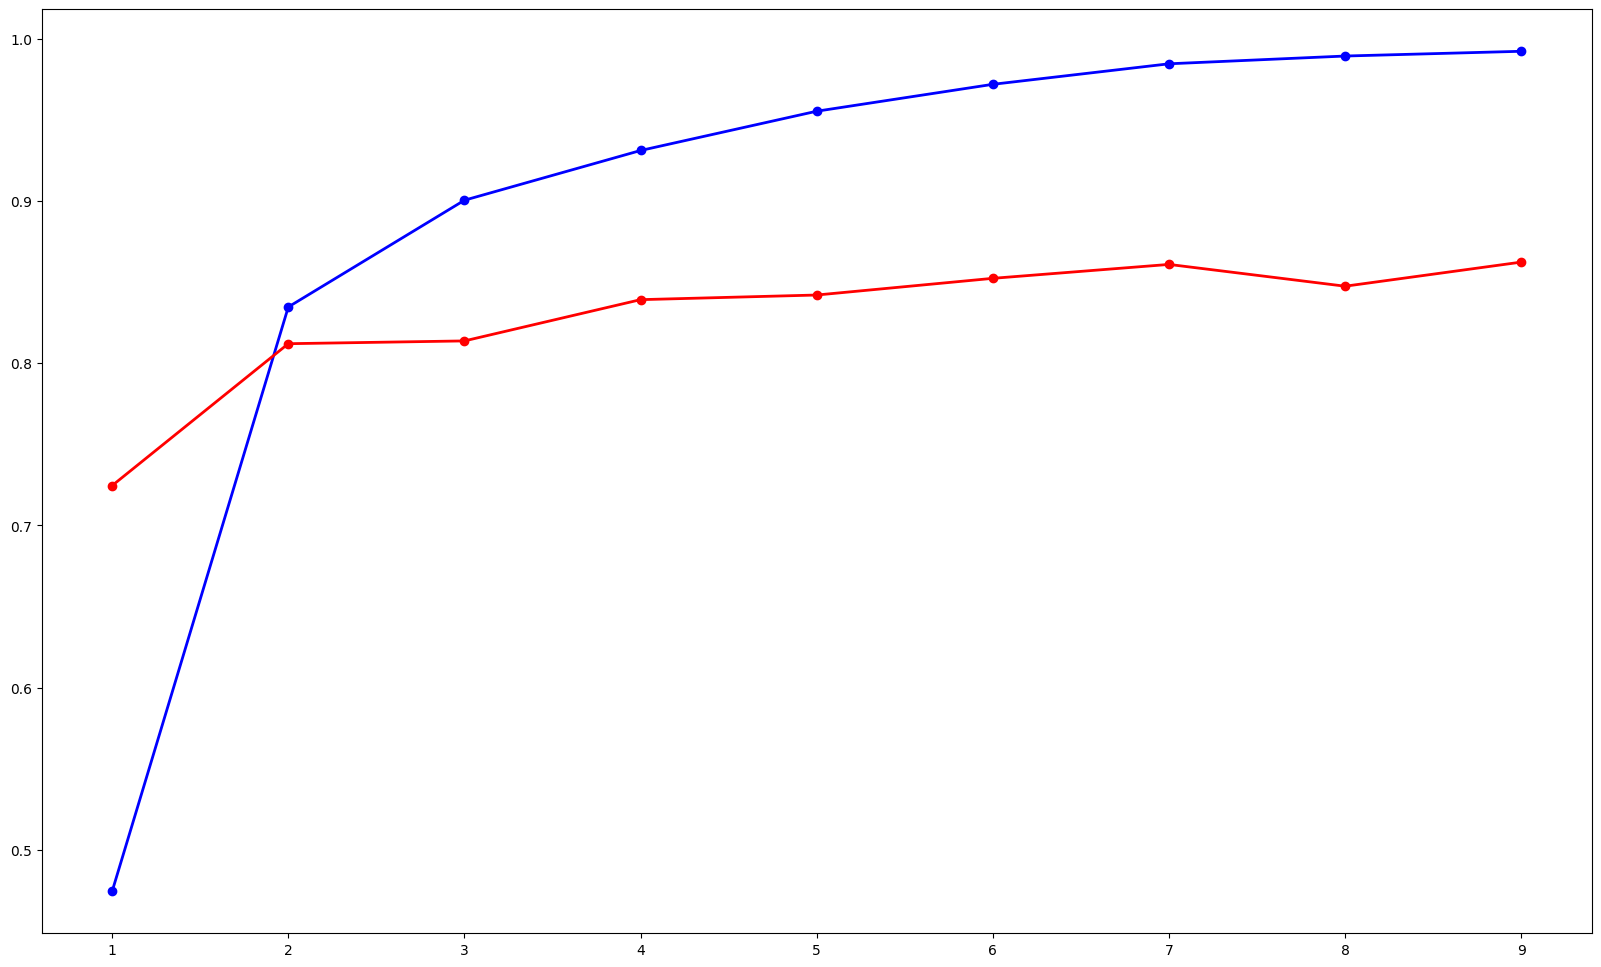

In [ ]:
fig = plt.figure(figsize=(20, 12))

# # 1. Training History
# ax1 = plt.subplot(3, 3, 1)
epochs_range = range(1, epochs)
ax1.set_xlabel('Epoch', fontsize=12)
ax1.set_ylabel('Accuracy', fontsize=12)
ax1.set_title('Model Accuracy Over Time', fontsize=14, fontweight='bold')
ax1.legend()
ax1.grid(True, alpha=0.3)

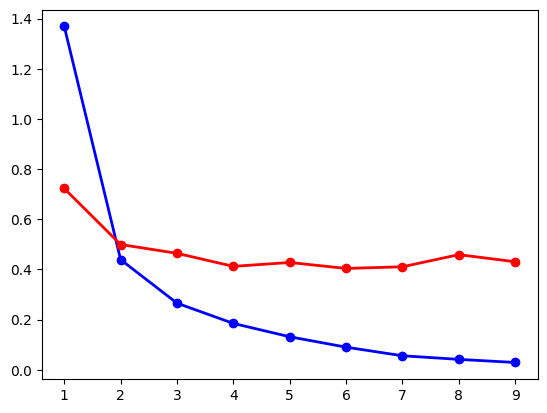

In [ ]:
plt.plot(epochs_range, train_losses, 'b-o', label='Train', linewidth=2)
plt.plot(epochs_range, val_losses, 'r-o', label='Validation', linewidth=2)

In [15]:
processor = AutoProcessor.from_pretrained(BEST_DIR)
model = AutoModelForImageClassification.from_pretrained(BEST_DIR).to(DEVICE)
model.eval()

The image processor of type `ViTImageProcessor` is now loaded as a fast processor by default, even if the model checkpoint was saved with a slow processor. This is a breaking change and may produce slightly different outputs. To continue using the slow processor, instantiate this class with `use_fast=False`. 


Loading weights: 100%|██████████| 200/200 [00:00<00:00, 1406.24it/s, Materializing param=vit.layernorm.weight]                                 


ViTForImageClassification(
  (vit): ViTModel(
    (embeddings): ViTEmbeddings(
      (patch_embeddings): ViTPatchEmbeddings(
        (projection): Conv2d(3, 768, kernel_size=(16, 16), stride=(16, 16))
      )
      (dropout): Dropout(p=0.0, inplace=False)
    )
    (encoder): ViTEncoder(
      (layer): ModuleList(
        (0-11): 12 x ViTLayer(
          (attention): ViTAttention(
            (attention): ViTSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
            )
            (output): ViTSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.0, inplace=False)
            )
          )
          (intermediate): ViTIntermediate(
            (dense): Linear(in_features=768, out_features=3072, bias=True)
            (intermed

In [ ]:
print("\n" + "="*60)
print("Evaluation................")
print("="*60)


model.eval()

all_predictions = []
all_probabilities = []  # will become (N, C)
all_labels = []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        batch_X = batch_X.to(DEVICE)
        batch_y = batch_y.to(DEVICE)

        outputs = model(pixel_values=batch_X)
        probs = torch.softmax(outputs.logits, dim=1)
        preds = outputs.logits.argmax(dim=1)

        all_probabilities.append(probs.cpu().numpy())
        all_predictions.append(preds.cpu().numpy())
        all_labels.append(batch_y.cpu().numpy())

all_probabilities = np.concatenate(all_probabilities, axis=0)
all_predictions = np.concatenate(all_predictions, axis=0)
all_labels = np.concatenate(all_labels, axis=0)


Evaluation................


In [ ]:
outputs.logits

tensor([[-1.9204, -2.7264, -0.6998, -3.3883,  3.3728,  0.7678,  3.6638],
        [-1.8418, -3.7144,  0.0999,  1.0032,  1.9212,  2.1706,  0.1771],
        [-1.3008, -2.7169, -2.8187, -1.2704,  2.9845,  0.3346,  4.1203],
        [-3.3794, -3.2116, -0.2934, -2.0421,  2.0003,  2.7566,  4.5291],
        [ 1.2454, -3.7923,  0.4933,  0.8353,  0.2668, -0.1100,  1.0859],
        [-4.3944, -3.1346, -0.8259,  1.2213,  3.9826, -1.6012,  4.9785],
        [-2.4586, -2.6583, -0.4068,  0.7418,  3.8589, -1.8366,  4.2987],
        [-3.9081, -3.0801, -0.0617,  3.6496,  2.5980, -1.5587,  3.0027],
        [-4.0256, -1.9446, -1.0749, -1.6027,  3.6513, -1.6756,  5.1119],
        [-0.5396, -3.7441, -1.3184,  0.3706,  2.1995,  2.3378,  0.8359],
        [-1.4459, -1.4532, -1.0509, -0.4083,  2.0307, -0.4056,  2.2381],
        [-3.4498, -2.6728, -0.3279, -1.1689,  2.5013, -1.4286,  6.0008]],
       device='cuda:0')

In [ ]:
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, classification_report, confusion_matrix

acc = accuracy_score(all_labels, all_predictions)
bacc = balanced_accuracy_score(all_labels, all_predictions)
f1_macro = f1_score(all_labels, all_predictions, average="macro")
f1_weighted = f1_score(all_labels, all_predictions, average="weighted")

print("Accuracy:", acc)
print("Balanced Acc:", bacc)
print("F1 macro:", f1_macro)
print("F1 weighted:", f1_weighted)

cm = confusion_matrix(all_labels, all_predictions)
print("CM shape:", cm.shape)  # (7,7)

print(classification_report(all_labels, all_predictions, target_names=datasets_name, digits=4, zero_division=0))

Accuracy: 0.8522857142857143
Balanced Acc: 0.8522857142857143
F1 macro: 0.8506524761729002
F1 weighted: 0.8506524761729002
CM shape: (7, 7)
              precision    recall  f1-score   support

       glide     0.9317    0.6820    0.7875       500
  midjourney     0.9878    0.9720    0.9798       500
      wukong     0.9344    0.9400    0.9372       500
         adm     0.8182    0.9180    0.8652       500
        sdv5     0.6964    0.8120    0.7498       500
        vqdm     0.8685    0.9640    0.9137       500
      biggan     0.7705    0.6780    0.7213       500

    accuracy                         0.8523      3500
   macro avg     0.8582    0.8523    0.8507      3500
weighted avg     0.8582    0.8523    0.8507      3500



In [ ]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_auc_score

C = all_probabilities.shape[1]
Y_true = label_binarize(all_labels, classes=list(range(C)))
auc_macro_ovr = roc_auc_score(Y_true, all_probabilities, multi_class="ovr", average="macro")
print("ROC-AUC macro (OvR):", auc_macro_ovr)

ROC-AUC macro (OvR): 0.9841965714285713


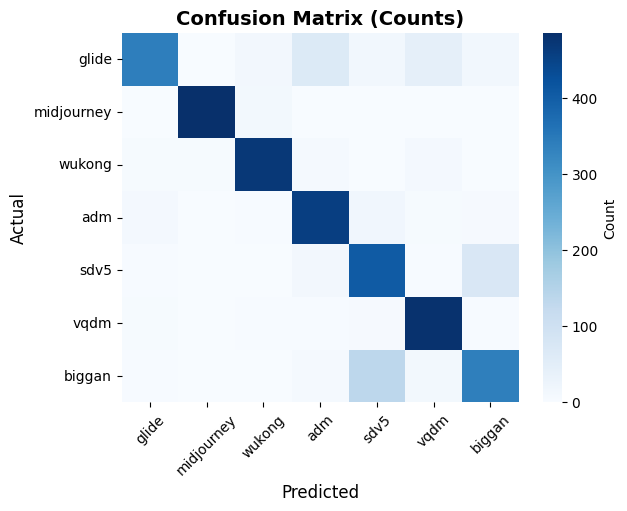

In [ ]:

sns.heatmap(
    cm, annot=False, fmt='d', cmap='Blues',
    xticklabels=datasets_name, yticklabels=datasets_name,
    cbar_kws={'label': 'Count'}
)
plt.title('Confusion Matrix (Counts)', fontsize=14, fontweight='bold')
plt.ylabel('Actual', fontsize=12)
plt.xlabel('Predicted', fontsize=12)
plt.tick_params(axis='x', rotation=45)

In [20]:
def get_image(path):
    img_size= (IMG_SIZE,IMG_SIZE)
    response = requests.get(url=path)
    img = Image.open(BytesIO(response.content))
    img = img.convert(mode="RGB")
    img = img.resize(img_size)
    print(f"picture size : {img_size}; mode : {img.mode}")
    return img


In [25]:
import torch
from PIL import Image

def predict_image(path, val_tfms, model, device):
    model.eval()
    img = get_image(path)
    x = test_tfms(img).unsqueeze(0).to(device)  # (1,3,224,224)

    with torch.no_grad():
        logits = model(pixel_values=x).logits     # (1,C)
        probs = torch.softmax(logits, dim=1)[0]    # (C,)
        pred_id = int(probs.argmax().item())
        pred_label = model.config.id2label[pred_id]
        confidence = float(probs[pred_id].item())

    return pred_label, confidence, probs.cpu().numpy()

In [26]:
mid_example = 'https://embracepresets.com/wp-content/uploads/2023/06/theart1300_Realistic_portrait_of_a_young_woman_with_sea-blue__93a47bc9-aebe-4a35-9249-f9bd564e3d88_2.png'

picture size : (224, 224); mode : RGB


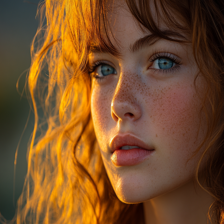

In [27]:
get_image(mid_example)

In [28]:
label, conf, probs = predict_image(mid_example, val_tfms, model, DEVICE)
print("pred:", label, "conf:", conf)

picture size : (224, 224); mode : RGB
pred: midjourney conf: 0.994024932384491
